In [2]:
import numpy as np, matplotlib.pyplot as plt, glob, os, regex as re, matplotlib as mpl, \
    scipy.stats as stats, seaborn as sns, scipy as sp, matplotlib.gridspec as gridspec, \
    matplotlib.colors as mplcol, simplification.cutil as simpl, pandas as pd, colorcet
from skimage.filters import gaussian

In [3]:
MODE = 'wavelet' # 'rawmvmt'

### Specify data files to display

In [4]:
if MODE == 'wavelet':
    fnameBases = ['\\\\?\\Z:\\behavior\\*\\wavelet\\wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy',
                  '\\\\?\\Z:\\behavior\\*\\wavelet\\wavelet_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
    ]
else:
    fnameBases = ['\\\\?\\Z:\\behavior\\*\\wavelet\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy',
                  '\\\\?\\Z:\\behavior\\*\\wavelet\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
    ]

In [5]:
fnames = [[(x if i == 0 else None) for x in glob.glob(fnameBase) if 'RIG' not in x] \
          for i, fnameBase in enumerate(fnameBases)]

fnames[1] = [x.replace(os.path.basename(fnameBases[0]), os.path.basename(fnameBases[1])) for x in fnames[0]]

len(fnames[0]), fnames[0][0:2]

(21,
 ['\\\\?\\Z:\\behavior\\4-10-19-b\\wavelet\\wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy',
  '\\\\?\\Z:\\behavior\\4-11-19-a\\wavelet\\wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'])

In [6]:
# Load data
Hs = [[], []]
for k in range(2):
    arrs = []
    for fname in fnames[k]:
        arr = np.load(fname)
        arr = arr[~np.any(np.isnan(arr), axis=1)]
        arrs.append(arr)

    # Determine data range
    _max, _min = np.max(np.vstack(arrs), axis=0), np.min(np.vstack(arrs), axis=0)

    # Compute histograms
    for arr in arrs:
        H, _, _ = np.histogram2d(
            arr[:,0], arr[:,1],
            bins=(200, 200), 
            range=((_min[0], _max[0]), (_min[1], _max[1])))

        # Clip
        H = np.clip(H, 0, np.percentile(H, 99))
        H = H / np.sum(H)

        Hs[k].append(H)

In [7]:
def jsd(p, q, base=np.e):
    """Implementation of pairwise `jsd` based on: 
       https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    """
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 0.5 * (p + q)
    return stats.entropy(p.flatten(), m.flatten(), base=base)/2. + \
        sp.stats.entropy(q.flatten(), m.flatten(), base=base)/2.

In [8]:
# Determine spider ID labels
def getSpiderID(x):
    k = ['a', 'b', 'd', 'e', 'mvs~'].index(re.search('[0-9]+-[0-9]+-[0-9]+-([a-z~]*)', x).group(1))
    return ['A', 'B', 'C', 'D', 'E'][k]

In [9]:
# Wong colorblind-safe palette
# Source: https://www.nature.com/articles/nmeth.1618
# Source: https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
COLORS = [
    (0, 0, 0),
    (230, 159, 0),
    (0, 158, 115),
    (204, 121, 167),
    (86, 180, 233)
]
COLORS = [mplcol.rgb2hex(np.array(x) / 255.0) for x in COLORS]

In [10]:
import colorcet
import matplotlib.colors
import matplotlib.cm as cm

class customColormap(matplotlib.colors.LinearSegmentedColormap):
    def __init__(self, *args, **kwargs):
        self.baseCM = cm.get_cmap('cet_CET_L17')
        self.N = self.baseCM.N
    def __call__(self, r, *args, **kwargs):
        def mapColor(x):
            _c = self.baseCM(0.0, *args, **kwargs)
            lim = 0.10
            if x >= lim:
                return self.baseCM((x-lim)/(1.0 - lim), *args, **kwargs)
            else: 
                if isinstance(_c[0], float):
                    z = (x / 0.05)
                    a = _c[0] * z + 1.0 * (1 - z)
                    b = _c[1] * z + 1.0 * (1 - z)
                    c = _c[2] * z + 1.0 * (1 - z)
                    _c = (a, b, c, 1.0)
                    return _c
                else:
                    z = (x / lim)
                    a = int(_c[0] * z + 255.0 * (1 - z))
                    b = int(_c[1] * z + 255.0 * (1 - z))
                    c = int(_c[2] * z + 255.0 * (1 - z))
                    _c = (a, b, c, 255)
                    return _c
        if r.ndim == 2:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([[mapColor(y) for y in x] for x in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        elif r.ndim == 1:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([mapColor(y) for y in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        else:
            print('!!')

### Plot density

In [11]:
pos = [np.load(glob.glob(os.path.abspath(os.path.join(fn, 
    '../../croprot/*_dlc_position_orientation.npy')))[0]
        )[:,0:2] for fn in fnames[0]]

In [12]:
pos = [pd.DataFrame(x).fillna(method='ffill').fillna(method='bfill').values for x in pos]

C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


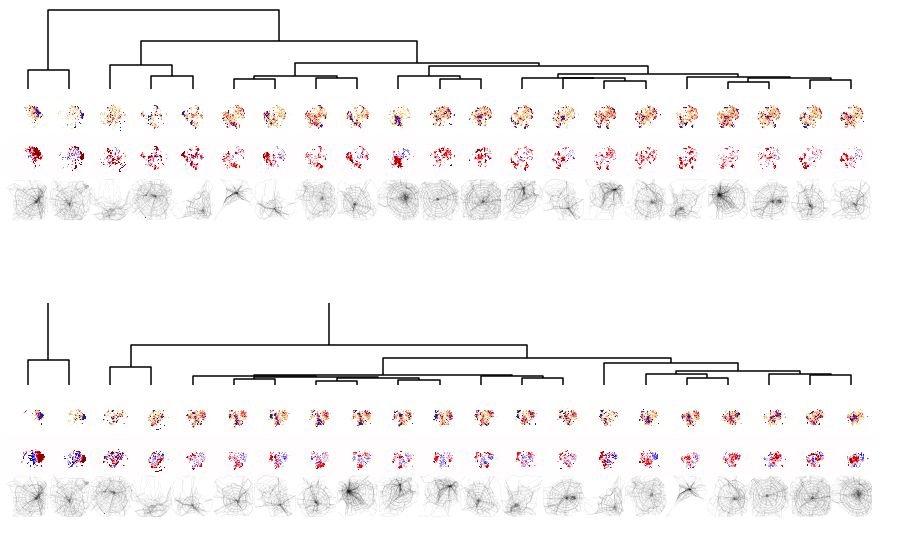

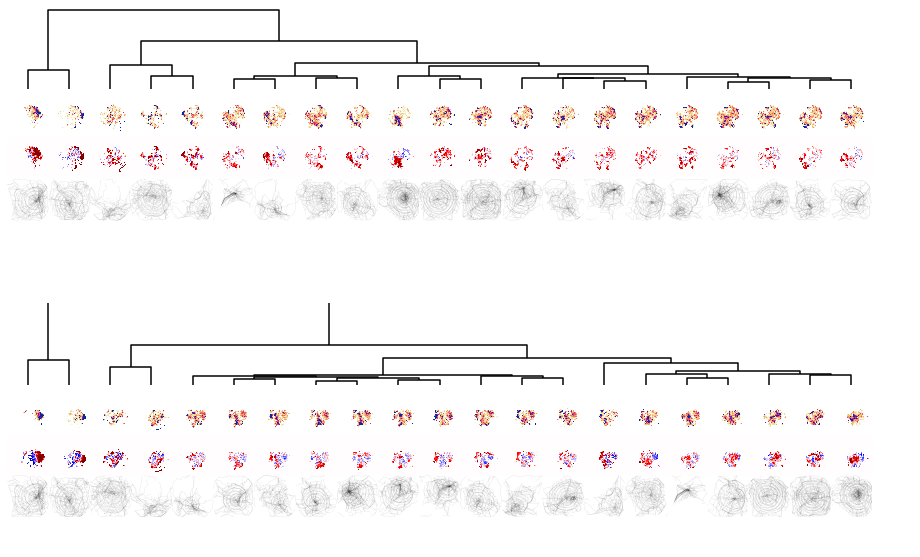

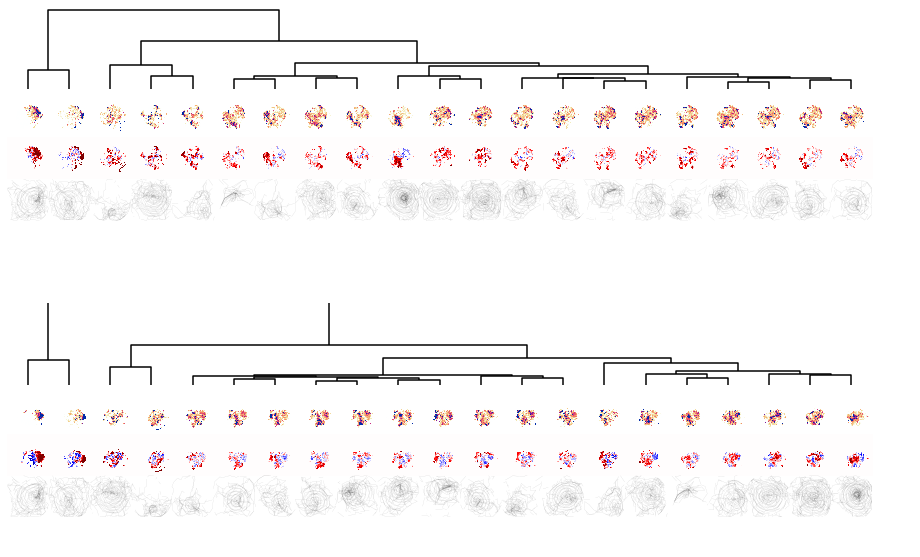

In [14]:
ssTSNE = ((50, 150), (50, 150))
if MODE == 'wavelet':
    ssTSNE = ((0, 200), (0, 200))

_cm = customColormap()
for resVW in [500, 1000, 2000]:
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    for k in [0,1]:
        # Compute pairwise distances
        distMtx = np.zeros((len(Hs[0]), len(Hs[0])), dtype=np.float64)
        for i1 in range(distMtx.shape[0]):
            for i2 in range(distMtx.shape[1]):
                distMtx[i1, i2]  = jsd(Hs[0][i1], Hs[0][i2]) * k
                distMtx[i1, i2] += jsd(Hs[1][i1], Hs[1][i2]) * (1-k)

        link = sp.cluster.hierarchy.linkage(np.hstack((distMtx, distMtx.T)), 
            method='ward', metric='euclidean')

        dendr = sp.cluster.hierarchy.dendrogram(link, 
            ax=ax[k], link_color_func=lambda x:'black')

        order = sp.cluster.hierarchy.leaves_list(link)

        ax[k].set_xlim(0, 220)
        ax[k].set_ylim(-4, 2)
        ax[k].set_axis_off()

        for i in range(len(order)):
            ax[k].imshow(Hs[1-k][order[i]][ssTSNE[0][0]:ssTSNE[0][1], ssTSNE[1][0]:ssTSNE[1][1]],
                extent=(i*10, i*10 + 10, -1.2, -0.2), aspect=10, cmap=_cm)
            
            # Plot z-score
            a = [gaussian(x, 1) for x in Hs[1-k]]
            zscore = (a[order[i]] - np.mean(a, axis=0)) / np.std(a, axis=0)
            zscore[np.isnan(zscore)] = 0
            zscore[a[order[i]] < np.percentile(a[order[i]], 90)] = 0
            ax[k].imshow(zscore[ssTSNE[0][0]:ssTSNE[0][1], ssTSNE[1][0]:ssTSNE[1][1]],
                extent=(i*10, i*10 + 10, -2.2, -1.2), aspect=10, vmin=-3, vmax=3, cmap='seismic')
            
            # Plot webs
            xy = pos[order[i]].copy()
            xy = xy[np.linalg.norm(xy - np.array([500, 500])[np.newaxis, :], axis=1) < 550,:]
            xy = simpl.simplify_coords_vw(xy, resVW)
            segmentIDs = np.cumsum(np.linalg.norm(xy - 
                np.roll(xy, 1, axis=0), axis=1) > 200)
            xy -= np.min(xy, axis=0)[np.newaxis, :]
            xy /= np.max(xy, axis=0)[np.newaxis, :]

            xy[:,0] *= 10
            xy += np.array([i*10, -3.2])[np.newaxis, :]

            for sid in np.unique(segmentIDs):
                ax[k].plot(xy[segmentIDs==sid, 0], 
                           xy[segmentIDs==sid, 1], linewidth=0.04, color='black')

    fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_Suppl_6_{}_{}.pdf'.format(resVW, MODE), dpi=1000)

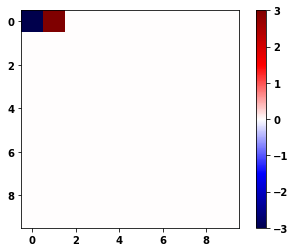

In [32]:
tmp = np.zeros((10, 10))
tmp[0,0] = -3
tmp[0,1] = 3
plt.imshow(tmp, cmap='seismic')
plt.colorbar()
plt.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_Suppl_6_colorbar.pdf')